In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches  # draw rectangle
from matplotlib.ticker import MultipleLocator as ML  # draw minor ticks
from scipy.interpolate import griddata
from scipy.interpolate import LinearNDInterpolator as LNDI
from scipy.interpolate import NearestNDInterpolator as NNDI

In [2]:
pd.options.display.max_colwidth = 100
#%matplotlib inline
#%matplotlib notebook

### Load Dataset

In [3]:
cloud_filepath = r"C:\home\workspace\20210201_清水建設_シールドトンネル_2021-01-AHランプ\20210108shimizuGRTC-A(No23_27)_cylinder_origin_plane_connect_planemodel.csv"
coeffs_filepath = r"C:\home\workspace\20210201_清水建設_シールドトンネル_2021-01-AHランプ\20210108shimizuGRTC-A(No23_27)_cylinder_origin_plane_connect_planemodel_coeffs.csv"
#cloud_filepath = r"C:\home\workspace\20210201_清水建設_シールドトンネル_2021-01-AHランプ\20210108shimizuP50-A(No23_27)_subsample0.0012_cylinder_origin_plane_connect_planemodel.csv"
#coeffs_filepath = r"C:\home\workspace\20210201_清水建設_シールドトンネル_2021-01-AHランプ\20210108shimizuP50-A(No23_27)_subsample0.0012_cylinder_origin_plane_connect_planemodel_coeffs.csv"
#cloud_filepath = r"C:\home\workspace\20210201_清水建設_シールドトンネル_2021-01-AHランプ\20210108shimizuP50-A(No23_27)_subsample0.0012_cylinder_origin_plane_decimate0.9_connect_planemodel.csv"
#coeffs_filepath = r"C:\home\workspace\20210201_清水建設_シールドトンネル_2021-01-AHランプ\20210108shimizuP50-A(No23_27)_subsample0.0012_cylinder_origin_plane_decimate0.9_connect_planemodel_coeffs.csv"
#cloud_filepath = r"C:\home\develop\pointcloud_experiment\out\build\x64-Release\plane_segment_sample_decimate0.9_clean.csv"
#coeffs_filepath = r"C:\home\develop\pointcloud_experiment\out\build\x64-Release\plane_segment_sample_decimate0.9_planecoeffs.csv"

In [4]:
save_dirpath = os.path.split(cloud_filepath)[0]
cloud_filename = os.path.split(cloud_filepath)[1]
print(save_dirpath)
print(cloud_filename)

C:\home\workspace\20210201_清水建設_シールドトンネル_2021-01-AHランプ
20210108shimizuGRTC-A(No23_27)_cylinder_origin_plane_connect_planemodel.csv


In [5]:
# load pointcloud: x,y,z,region_id 
df = pd.read_csv(cloud_filepath, sep='\t')
df.describe()

,x,y,z,region_id
count,4.043901e+07,4.043901e+07,4.043901e+07,4.043901e+07
mean,1.539272e+00,1.589745e+01,-2.055561e-04,1.490494e+01
std,1.307179e+00,6.937674e+00,2.232165e-03,1.018781e+01
min,-1.866932e+00,1.715246e+00,-6.499767e-03,0.000000e+00
25%,6.674569e-01,1.192857e+01,-1.769066e-03,4.000000e+00
50%,1.824746e+00,1.619602e+01,-1.416206e-04,1.500000e+01
75%,2.682429e+00,1.924436e+01,1.374722e-03,2.400000e+01
max,5.034000e+00,3.079741e+01,8.509636e-03,3.200000e+01


In [6]:
# load estimated plane model coeffs: region_id,a,b,c,d 
df_coeffs = pd.read_csv(coeffs_filepath, sep="\t")
df_coeffs.head()

,region_id,a,b,c,d
0,0,-0.000204,-0.000115,1.000000,0.001732
1,1,-0.002427,0.000962,0.999997,-0.022384
2,2,-0.001263,-0.000042,0.999999,-0.000300
3,3,0.000183,0.000113,1.000000,-0.004014
4,4,-0.000520,0.000008,1.000000,0.002209


### Selection

In [7]:
region_id_selection = [23, 6, 26, 8, 27, 24]
#region_id_selection = [16, 38, 31, 1, 14]  # 20210108shimizuP50-A(No23_27)_subsample0.0012_cylinder_origin_plane_connect_planemodel.csv
#region_id_selection = [13, 29, 37, 9, 64]  # 20210108shimizuP50-A(No23_27)_subsample0.0012_cylinder_origin_plane_decimate0.9_connect_planemodel
df_ = pd.DataFrame()
for region_id in region_id_selection:
    df_ = pd.concat([df_, df[df.region_id == region_id]])
df = df_

### Region ID List

In [8]:
# extract index and retion_id
region_id_list = df.region_id.drop_duplicates().values  # must be equal with df_coeffs.region_id.values
region_id_list.sort()
for i in range(len(region_id_list)):
    print('index: %s region_id: %s' % (i, region_id_list[i]))
if len(region_id_list) != len(df.region_id.drop_duplicates()):
    print('Error: df and df_coeffs is not matched')

index: 0 region_id: 6.0
index: 1 region_id: 8.0
index: 2 region_id: 23.0
index: 3 region_id: 24.0
index: 4 region_id: 26.0
index: 5 region_id: 27.0


### Grid definition

In [9]:
dx = dy = 0.001
nx = int((np.max(df.x) - np.min(df.x)) / dx)
ny = int((np.max(df.y) - np.min(df.y)) / dy)
print('data size: (%s, %s)' % (nx, ny))
x = np.linspace(np.min(df.x), np.max(df.x), nx)
y = np.linspace(np.min(df.y), np.max(df.y), ny)
gx, gy = np.meshgrid(x, y)

data size: (2987, 6764)


### Plot settings

In [10]:
# common plot settings
def set_plot_label():
    plt.ylim(np.min(x), np.max(x))
    plt.xlim(np.min(y), np.max(y))
    plt.ylabel('Tunnel depth [m]')
    plt.xlabel('R*theta [m]')
    plt.axes().xaxis.set_minor_locator(ML(0.1))  # todo: this makes warning
    plt.axes().yaxis.set_minor_locator(ML(0.1))

def save_plot(filepath):
    plt.savefig(filepath, bbox_inches="tight", pad_inches=0.1, dpi=300, facecolor='white')
    
# max(x)-->min(x) because always plot is transposed
extent_transposed = [np.min(y), np.max(y), np.max(x), np.min(x)]

In [11]:
def gz_measured(region_id):
    x_arr = df[df.region_id == region_id].x
    y_arr = df[df.region_id == region_id].y
    z_arr = df[df.region_id == region_id].z
    interp = LNDI(list(zip(x_arr,y_arr)), z_arr)  # LNDI fill np.nan outside of cenvex hull
    return interp(gx, gy)  # return grid z

In [12]:
gz_measured_list = []
for region_id in region_id_list:
    gz_measured_list.append(gz_measured(region_id))

<ipython-input-10-44a23a5c59df>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_minor_locator(ML(0.1))  # todo: this makes warning
<ipython-input-10-44a23a5c59df>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().yaxis.set_minor_locator(ML(0.1))


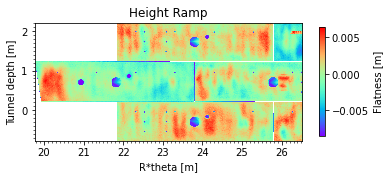

In [13]:
# visualize height ramp
fig_title = 'Height Ramp'
for gz in gz_measured_list:
    plt.imshow(-gz.transpose(), cmap='rainbow', extent=extent_transposed, interpolation='none')
cbar = plt.colorbar(shrink=0.5)  # orientation='horizontal'
cbar.set_label('Flatness [m]')
set_plot_label()
plt.title(fig_title)
save_plot(os.path.join(save_dirpath, cloud_filename + '_' + fig_title + '.png' ))
plt.show()

### Region mask

In [14]:
# create region mask
# true: inside region  false: outside region
region_mask_list = []
for gz in gz_measured_list:
    region_mask_list.append(~np.isnan(gz))
all_region_mask = np.zeros((ny, nx), dtype=bool)  # all false array
for mask in region_mask_list:
    all_region_mask = all_region_mask | mask

<ipython-input-10-44a23a5c59df>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_minor_locator(ML(0.1))  # todo: this makes warning
<ipython-input-10-44a23a5c59df>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().yaxis.set_minor_locator(ML(0.1))


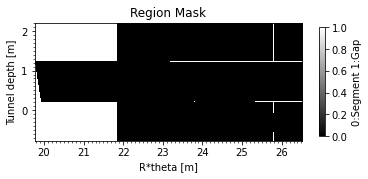

In [15]:
# visualize gap between regions
fig_title = 'Region Mask'
plt.imshow(~all_region_mask.transpose(), cmap='gray', extent=extent_transposed, vmin=0, vmax=1, interpolation='none')
cbar = plt.colorbar(shrink=0.5)  # orientation='horizontal'
cbar.set_label('0:Segment 1:Gap')
set_plot_label()
plt.title(fig_title)
save_plot(os.path.join(save_dirpath, cloud_filename + '_' + fig_title + '.png' ))
plt.show()

### Plane model reconstruction

In [16]:
def plane_coeffs(region_id):
    coeffs = df_coeffs[df_coeffs.region_id == region_id].values[0]  # df: region_id,a,b,c,d dataset
    return coeffs[1], coeffs[2], coeffs[3], coeffs[4]  # a, b, c, d in plane eq.

def z_model(x, y, *coeffs):
    a = coeffs[0][0]
    b = coeffs[0][1]
    c = coeffs[0][2]
    d = coeffs[0][3]
    return -(d + a*x + b*y) / c

def gz_model(region_id):
    coeffs = plane_coeffs(region_id)
    return z_model(gx, gy, coeffs)

In [17]:
gz_model_list = []
for i, region_id in enumerate(region_id_list):
    gz = gz_model(region_id)
    mask = region_mask_list[i]
    gz_masked = np.ma.masked_array(gz, ~mask, fill_value=np.nan)  # fill nan at outside region
    gz_model_list.append(gz_masked.filled())

<ipython-input-10-44a23a5c59df>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_minor_locator(ML(0.1))  # todo: this makes warning
<ipython-input-10-44a23a5c59df>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().yaxis.set_minor_locator(ML(0.1))


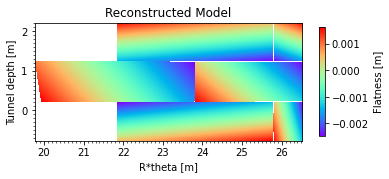

In [18]:
# visualize models
fig_title = 'Reconstructed Model'
for gz in gz_model_list:
    plt.imshow(-gz.transpose(), cmap='rainbow', extent=extent_transposed, interpolation='none')
cbar = plt.colorbar(shrink=0.5)  # orientation='horizontal'
cbar.set_label('Flatness [m]')
set_plot_label()
plt.title(fig_title)
save_plot(os.path.join(save_dirpath, cloud_filename + '_' + fig_title + '.png' ))
plt.show()

### Region (Shield Tunnel Segment) map

In [19]:
gz_region_list = []
for i, region_id in enumerate(region_id_list):
    gz = np.zeros((ny, nx), dtype=float)  # must be float to use nan
    gz.fill(region_id)
    mask = region_mask_list[i]
    gz_masked = np.ma.masked_array(gz, ~mask, fill_value=np.nan)  # fill nan at outside region
    gz_region_list.append(gz_masked.filled())

<ipython-input-10-44a23a5c59df>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_minor_locator(ML(0.1))  # todo: this makes warning
<ipython-input-10-44a23a5c59df>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().yaxis.set_minor_locator(ML(0.1))


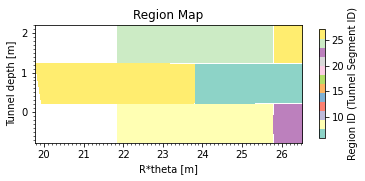

In [20]:
# visualize regions 
fig_title = 'Region Map'
for gz in gz_region_list:
    plt.imshow(gz.transpose(), cmap='Set3', extent=extent_transposed, vmin=np.min(region_id_list), vmax=np.max(region_id_list), interpolation='none')
cbar = plt.colorbar(shrink=0.5)  # orientation='horizontal'
cbar.set_label('Region ID (Tunnel Segment ID)')
set_plot_label()
plt.title(fig_title)
save_plot(os.path.join(save_dirpath, cloud_filename + '_' + fig_title + '.png' ))
plt.show()

### Merge arrays

In [21]:
# todo: refactor for speed up
def merge_2d_array(src_arr, dst_arr):
    if src_arr.shape != dst_arr.shape:
        print("assert: source and destination array shape is not match")
    for j in range(src_arr.shape[0]):
        for i in range(src_arr.shape[1]):
            if not np.isnan(src_arr[j][i]):
                dst_arr[j][i] = src_arr[j][i]    

In [22]:
# merge gz height list
gz_measured = np.zeros((ny, nx), dtype=float)
gz_measured.fill(np.nan)
for gz in gz_measured_list:
    merge_2d_array(gz, gz_measured)

In [ ]:
# merget gz mdoel list
gz_model = np.zeros((ny, nx), dtype=float)
gz_model.fill(np.nan)
for gz in gz_model_list:
    merge_2d_array(gz, gz_model)

In [ ]:
# visualize height ramp
fig_title = 'Height Ramp - Merged'
plt.imshow(-gz_measured.transpose(), cmap='rainbow', extent=extent_transposed, interpolation='none')
cbar = plt.colorbar(shrink=0.5)  # orientation='horizontal'
cbar.set_label('Flatness [m]')
set_plot_label()
plt.title(fig_title)
save_plot(os.path.join(save_dirpath, cloud_filename + '_' + fig_title + '.png' ))
plt.show()

In [ ]:
# visualize reconstructed model
fig_title = 'Reconstructed Model - Merged'
plt.imshow(-gz_model.transpose(), cmap='rainbow', extent=extent_transposed, interpolation='none')
cbar = plt.colorbar(shrink=0.5)  # orientation='horizontal'
cbar.set_label('Flatness [m]')
set_plot_label()
plt.title(fig_title)
save_plot(os.path.join(save_dirpath, cloud_filename + '_' + fig_title + '.png' ))
plt.show()

In [ ]:
#save_plot(os.path.join(save_dirpath, cloud_filename + '_' + fig_title + '_up.png' ))

### Line Profile

In [ ]:
def find_index(arr, val):
    eps = 1e-8
    found = np.where(arr >= val - eps)[0]
    if (len(found)):
        return found[0]
    else:
        return 0

In [ ]:
def find_nan_sequence(arr):
    # return: nan pairs list
    # exp)
    # in:  [nan  1.  3.  4.  3. nan nan 32. 42. nan nan 10.]
    # out: [0, 0, 5, 6, 9, 10]
    nan_list = np.where(np.isnan(arr))[0]
    if len(nan_list) == 0:
        return []
    nan_pairs = []
    prev_val = nan_list[0]
    for i in range(len(nan_list)):
        if len(nan_pairs) == 0 or np.isnan(nan_list[i]):
            nan_pairs.append(nan_list[i])
        elif prev_val + 1 != nan_list[i]:  # nan end
            nan_pairs.append(nan_list[i - 1])
            nan_pairs.append(nan_list[i])
        prev_val = nan_list[i]
    nan_pairs.append(nan_list[-1])
    return nan_pairs

In [ ]:
def find_gaps(fixed_position, fixed_axis='y'):
    if fixed_axis == 'y':
        fixed_index = find_index(y, fixed_position)
        v = x
        z = -gz_model[fixed_index,:]
    elif fixed_axis == 'x':
        fixed_index = find_index(x, fixed_position)
        v = y
        z = -gz_model[:,fixed_index]
    else:
        print('assert: fixed axis is y or x (variable axis is x or y)')
        return
    nan_sequence = find_nan_sequence(z)  # gap represented as [nan, nan, ...]
    if len(nan_sequence) % 2 != 0:
        print('assert: nan sequence is not array of begin-index and end-index pair')
    gaps = []
    for i in range(0, len(nan_sequence)-1, 2):
        gap_ibegin = nan_sequence[i] - 1
        gap_iend = nan_sequence[i+1] + 1
        if gap_ibegin <= 0 or gap_iend >= len(v):
            continue  # ignore edge of array
        if gap_iend - gap_ibegin > 50:  # 50mm at 0.01 resolution
            continue  # ignore large nan sequence
        gap_vbegin = v[gap_ibegin]
        gap_vend = v[gap_iend]
        gap_zbegin = z[gap_ibegin]
        gap_zend = z[gap_iend]
        if np.isnan(gap_zbegin) or np.isnan(gap_zend):
            continue
        if fixed_axis == 'y':
            gap = np.array([gap_vbegin, fixed_position, gap_zbegin, gap_vend, fixed_position, gap_zend])  # [x1,y1,z1,x2,y2,z2]
        elif fixed_axis == 'x':
            gap = np.array([fixed_position, gap_vbegin, gap_zbegin, fixed_position, gap_vend, gap_zend])            
        gaps.append(gap)
    return np.array(gaps)  # [[x1,y1,z1,x2,y2,z2], [x1,y1,z1,x2,y2,z2], ...]

In [ ]:
# visualize x direction line profile
y_fixed = 6.95  # 6.85, 6.95
fig_title = 'Line Profile - Rtheta %s [m]' % y_fixed 
gaps = find_gaps(y_fixed, 'y')
#print(gaps)
fig = plt.figure()
ax = plt.axes()
z_measured = -gz_measured.transpose()[:,find_index(y, y_fixed)]
z_model = -gz_model.transpose()[:,find_index(y, y_fixed)]
ax.scatter(x, z_measured, s=1, c='royalblue', label='Measured')
ax.plot(x, z_model, linewidth=1, c='black', label='Reconstructed model')
ax.set_xlabel('Tunnel depth [m]')
ax.set_ylabel('Flatness [m]')
#ax.axis('equal')
# draw rectangle as gap
comment = ""
for i, gap in enumerate(gaps):
    gap_width = gap[3] - gap[0]  # x width
    gap_height = gap[5] - gap[2]
    comment = comment + '(%s) gap width: %f [m], gap height: %f[m]\n' % (i+1, gap_width, gap_height)
    rect = patches.Rectangle((gap[0], gap[2]), width=gap_width, height=gap_height, linewidth=1, alpha=0.75, facecolor='red', label='Gap'+str(i+1))
    ax.add_patch(rect)
fig.text(0.14, 0.78, comment, size=9, c="black")
ax.legend(bbox_to_anchor=(1, 0), loc='lower right', borderaxespad=1, fontsize=9)
print(comment)
plt.title(fig_title)
save_plot(os.path.join(save_dirpath, cloud_filename + '_' + fig_title + '.png' ))
plt.show()

In [ ]:
#save_plot(os.path.join(save_dirpath, cloud_filename + '_' + fig_title + '_up.png' ))

In [ ]:
# visualize y direction line profile
x_fixed = -1.0
fig_title = 'Line Profile - Tunnel depth %s [m]' % x_fixed
gaps = find_gaps(x_fixed, 'x')
#print(gaps)
fig = plt.figure()
ax = plt.axes()
idx = find_index(x, x_fixed)
z_measured = -gz_measured[:,idx]
z_model = -gz_model[:,idx]
ax.scatter(y, z_measured, s=1, c='royalblue', label='Measured')
ax.plot(y, z_model, linewidth=1, c='black', label='Reconstructed model')
ax.set_xlabel('R*theta [m]')
ax.set_ylabel('Flatness [m]')
#ax.axis('equal')
# draw rectangle as gap
comment = ""
for i, gap in enumerate(gaps):
    gap_width = gap[4] - gap[1]  # y width
    gap_height = gap[5] - gap[2]
    comment = comment + '(%s) gap width: %f [m], gap height: %f[m]\n' % (i+1, gap_width, gap_height)
    rect = patches.Rectangle((gap[1], gap[2]), width=gap_width, height=gap_height, linewidth=1, alpha=0.75, facecolor='red', label='Gap'+str(i+1))
    ax.add_patch(rect)
fig.text(0.14, 0.78, comment, size=9, c="black")
ax.legend(bbox_to_anchor=(1, 0), loc='lower right', borderaxespad=1, fontsize=9)
print(comment)
plt.title(fig_title)
save_plot(os.path.join(save_dirpath, cloud_filename + '_' + fig_title + '.png' ))
plt.show()

In [ ]:
#save_plot(os.path.join(save_dirpath, cloud_filename + '_' + fig_title + '_up.png' ))

### Gap width, height map

In [ ]:
def toindex(val, offset, resolution):
    return int((val - offset) / resolution)

def xindex(val):
    return toindex(val, x[0], dx)

def yindex(val):
    return toindex(val, y[0], dy)

In [ ]:
# find gaps at x, y direction
xdirection_gaps_list = list(map(lambda val: find_gaps(val, 'y'), y))
ydirection_gaps_list = list(map(lambda val: find_gaps(val, 'x'), x))

In [ ]:
# create grid data
gap_width_map = np.zeros((ny, nx), dtype=float)
gap_width_map.fill(np.nan)
gap_height_map = np.zeros((ny, nx), dtype=float)
gap_height_map.fill(np.nan)
# fill x direction gap width and height
for gaps_list in xdirection_gaps_list:
    for gaps in gaps_list:
        j = yindex(gaps[1])
        gap_width = gaps[3] - gaps[0]  # x2 - x1
        gap_height = gaps[5] - gaps[2]  # z2 - z1
        for val in np.arange(gaps[0], gaps[3] + dx, dx):
            i = xindex(val)
            gap_width_map[j][i] = gap_width
            gap_height_map[j][i] = gap_height
# fill y direction gap width and height
for gaps_list in ydirection_gaps_list:
    for gaps in gaps_list:
        i = xindex(gaps[0])
        gap_width = gaps[4] - gaps[1]  # y2 - y1
        gap_height = gaps[5] - gaps[2]
        for val in np.arange(gaps[1], gaps[4] + dy, dy):
            j = yindex(val)
            gap_width_map[j][i] = gap_width
            gap_height_map[j][i] = gap_height

In [ ]:
# viusualize gap width
fig_title = 'Gap Width (Mehiraki)'
#plt.imshow(gap_width_map.transpose(), cmap='rainbow', extent=extent_transposed, vmin=np.nanmin(gap_width_map), vmax=np.nanmax(gap_width_map), interpolation='none')
plt.imshow(gap_width_map.transpose(), cmap='rainbow', extent=extent_transposed, vmin=np.nanmin(gap_width_map), vmax=0.012, interpolation='none')
cbar = plt.colorbar(shrink=0.5)  # orientation='horizontal'
cbar.set_label('Gap width [m]')
set_plot_label()
plt.title(fig_title)
save_plot(os.path.join(save_dirpath, cloud_filename + '_' + fig_title + '.png' ))
plt.show()

In [ ]:
# viusualize gap height
fig_title = 'Gap Height (Mechigai)'
plt.imshow(gap_height_map.transpose(), cmap='rainbow', extent=extent_transposed, vmin=np.nanmin(gap_height_map), vmax=np.nanmax(gap_height_map), interpolation='none')
cbar = plt.colorbar(shrink=0.5)  # orientation='horizontal'
cbar.set_label('Gap height [m]')
set_plot_label()
plt.title(fig_title)
save_plot(os.path.join(save_dirpath, cloud_filename + '_' + fig_title + '.png' ))
plt.show()

### Additional functions

In [ ]:
# create grid data
# x_arr, y_arr, z_arr: unorganized data set in np.array()
# resolution: 1 grid size
# interpolation_method: nearest, linear, cubic
# return grid of x, y, z
def resample_to_griddata(x_arr, y_arr, z_arr, resolution, interpolation_method='nearest'):
    dx = dy = resolution
    nx = int((np.max(x_arr) - np.min(x_arr)) / dx)
    ny = int((np.max(y_arr) - np.min(y_arr)) / dy)
    print('data size: (%s, %s)' % (nx, ny))
    x = np.linspace(np.min(x_arr), np.max(x_arr), nx)
    y = np.linspace(np.min(y_arr), np.max(y_arr), ny)
    gx, gy = np.meshgrid(x, y)
    points = np.array([x_arr, y_arr]).transpose()  # [x0,x1,...] and [y0,y1,...] ==> [[x0,y0], [x1,y1], ...]
    values = z_arr
    gz = griddata(points, values, (gx, gy), method=interpolation_method)
    return gx, gy, gz

In [ ]:
def save_griddata_to_csv(filepath, gx, gy, gz):
    if not gx.shape == gy.shape == gz.shape:
        print("Error: grid shape is not uniformed")
        return
    df = pd.DataFrame()
    df['x'] = gx.flatten()
    df['y'] = gy.flatten()
    df['z'] = gz.flatten()
    df.to_csv(filepath, sep='\t', index=None, header=True, compression='zip')

def load_griddata_from_csv(filepath):
    df = pd.read_csv(filepath, sep='\t', compression='zip')
    nx = len(df.x.drop_duplicates())
    ny = len(df.y.drop_duplicates())
    print('data size: (%s, %s)' % (nx, ny))
    gx = np.array(df.x).reshape(ny, nx)
    gy = np.array(df.y).reshape(ny, nx)
    gz = np.array(df.z).reshape(ny, nx)
    return gx, gy, gz

In [ ]:
#save_griddata_to_csv('region.csv.zip', gx_region, gy_region, gz_region)
#gx, gy, gz = load_griddata_from_csv('region.csv.zip')